In [4]:
from IMDBScraper import getSeriesInfo,getSeriesInfobySelenium
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from datetime import date
import textwrap
df=getSeriesInfo("0760437")

In [2]:
def setAxesLimits(df):
    #set timeline limits and rating limits
    global timelineRangeStart,timelineRangeEnd,ratingsStart,ratingsEnd

    firstDate=df.loc[0,"episodeDate"]
    lastDate=df.loc[0,"episodeDate"]

    lowestRating=df.loc[0,"episodeRating"]
    highestRating=df.loc[0,"episodeRating"]

    for i,row in df.iterrows():
        if row["episodeDate"]>lastDate:
            lastDate=row["episodeDate"]
        if row["episodeDate"]<firstDate:
            firstDate=row["episodeDate"]

        if row["episodeRating"]>highestRating:
            highestRating=row["episodeRating"]
        if row["episodeRating"]<lowestRating:
            lowestRating=row["episodeRating"]

    if firstDate.month<=4:firstMonth=1
    elif firstDate.month<=8:firstMonth=1
    elif firstDate.month<=12:firstMonth=1

    if lastDate.month<=4:
        lastMonth=4
        lastDay=30
    elif lastDate.month<=8:
        lastMonth=8
        lastDay=31
    elif lastDate.month<=12:
        lastMonth=12
        lastDay=31

    timelineRangeStart=str(firstDate.year)+"-"+str(firstMonth)+"-"+"1"
    timelineRangeEnd=str(lastDate.year)+"-"+str(lastMonth)+"-"+str(lastDay)
    timelineRangeStart=pd.to_datetime(timelineRangeStart)
    timelineRangeEnd=pd.to_datetime(timelineRangeEnd)


    ratingsStart=int(lowestRating)
    if highestRating == 10:highestRating=9
    ratingsEnd=int(highestRating)+1


def setAxes(ax):
    # Set labels for the axes
    ax.set_ylabel('Episode Rating')
    ax.set_xlabel('Episode Date')

    # Set the desired X-axis limits for a longer timeline
    ax.set_xlim(timelineRangeStart, timelineRangeEnd)
    ax.set_ylim(ratingsStart,ratingsEnd)
    
    # Set the positions of major ticks at the beginning of each year and set the labels to display only the years
    years = pd.date_range(start=timelineRangeStart, end=timelineRangeEnd, freq='YS')  # Generate yearly dates
    ax.set_xticks(years)
    ax.set_xticklabels([str(year.year) for year in years],fontsize=12)
    
    # Set the positions of subticks for each month within a year
    months = pd.date_range(start=timelineRangeStart, end=timelineRangeEnd, freq='MS')  # Generate monthly dates
    ax.set_xticks(months, minor=True)  # Use minor ticks for months

    # Label the minor ticks with month numbers (1-12) in a smaller font
    month_labels = [str(month.month) for month in months]
    ax.set_xticklabels(month_labels, minor=True, fontsize=10)
    
    # Move the year labels slightly below the X-axis
    ax.xaxis.set_tick_params(which='major', pad=15)
    
    # Decide number of ticks on the y-axis
    if (ratingsEnd-ratingsStart)<=1:
        majorTicksIncrement=0.5
        mainorTicksIncrement=0.25
    elif (ratingsEnd-ratingsStart)<=2:
        majorTicksIncrement=1
        minorTicksIncrement=0.25
    else:
        majorTicksIncrement=1
        minorTicksIncrement=0.5
    
    
    # Create the positions and labels for major ticks
    majorTicks = []
    current_value = ratingsStart
    
    while current_value <= ratingsEnd:
        majorTicks.append(current_value)
        current_value += majorTicksIncrement

    # Set the positions and labels of major ticks
    ax.set_yticks(majorTicks)
    ax.set_yticklabels(majorTicks)
    
    # Create the positions and labels for minor ticks
    minorTicks = []
    current_value = ratingsStart
    
    while current_value <= ratingsEnd:
        minorTicks.append(current_value)
        current_value += minorTicksIncrement
        
    # Set the positions and labels of minor ticks
    ax.set_yticks(minorTicks, minor=True)
    ax.set_yticklabels(minorTicks, minor=True, fontsize=8)
    
    
#     # Set the number of major ticks on the Y-axis
#     ax.yaxis.set_major_locator(plt.MaxNLocator(majorTicksNumber))  # Adjust the number of ticks as needed
    
#     # Add minor ticks in the Y-axis at minorLocator amount between each
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))

    # Set the Y-axis limits based on the minimum and maximum ratings
    ax.set_ylim(ratingsStart, ratingsEnd)

def setGrid(ax):
    # Show the plot
    ax.grid(color='gray', linestyle='--', linewidth=1)  # Change the grid color, style, and linewidth
    # Enable minor grids
    ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)


setAxesLimits(df)
print(ratingsStart,ratingsEnd,timelineRangeStart,timelineRangeEnd)

def addDate(ax):
    today = date.today()
    dateLabel=ax.text(pd.to_datetime(timelineRangeEnd),
            ratingsStart,
            str(today),
            fontsize=10,
            ha='right',
            va='bottom',
            zorder=5,
            color='black')

def addTitle(plt,ax,df):
    title=df.loc[0,"title"]
    rating=df["showRating"][0]
    plt.title(f"{title} (IMDB={rating})",fontsize=16, pad=30)
    #ax.set_title(title, fontsize=16)

6 10 2005-01-01 00:00:00 2008-04-30 00:00:00


In [3]:
means={}

def findSeasonNoList(df):
    seasonNoList=list(set(df["season"]))
    return seasonNoList


def findSeasonIntervals(df):    
    seasonNoList=findSeasonNoList(df)
    seasonIntervals={}

    for season in seasonNoList:
        firstDate=df[df['season']==season].reset_index(drop=True)["episodeDate"][0]
        lastDate=df[df['season']==season].reset_index(drop=True)["episodeDate"][0]
        for date in df[df['season']==season]["episodeDate"]:
            if firstDate>date: firstDate=date
            if lastDate<date: lastDate=date

        seasonIntervals[season]=[firstDate,lastDate]
    return seasonIntervals

def addseasonBackgrounds(df,ax):
    seasonIntervals=findSeasonIntervals(df)
    for season in seasonIntervals:
        start_x_value=seasonIntervals[season][0]
        end_x_value=seasonIntervals[season][1]
        # Set the background color of the shaded region
        ax.axvspan(start_x_value,
                   end_x_value,
                   color="#F0F0FA",
                   alpha=1,
                   zorder=1)

        # Set phaseLabels
        seasonLabel=ax.text(start_x_value+(end_x_value-start_x_value)/2,
                           ratingsEnd+0.05,
                           str(f"Season {season}"),
                           fontsize=12,
                           ha='center',
                           va='bottom',
                           zorder=5,
                           color="red",
                           alpha=1,
                           fontweight=None)
def addSeasonMeans(df,ax):
    global means
    seasonIntervals=findSeasonIntervals(df)
    for season in seasonIntervals:
        start_x_value=seasonIntervals[season][0]
        end_x_value=seasonIntervals[season][1]

        seasonMean=df[df['season']==season]["episodeRating"].mean()
        
        #Plot means
        ax.plot([start_x_value, end_x_value],
                [seasonMean, seasonMean],
                color="purple",
                alpha=0.5,
                zorder=2)
        
        # Set seasonMeanLabels
        
        if season==6 or season==8:
            seasonMeanLabel=ax.text(end_x_value+pd.Timedelta(1, "d"),
                                   seasonMean-0.01,
                                   str(f"S{season} Mean"),
                                   fontsize=10,
                                   ha='left',
                                   va='top',
                                   zorder=5,
                                   color="purple")
        else:
            seasonMeanLabel=ax.text(end_x_value+pd.Timedelta(1, "d"),
                                   seasonMean+0.01,
                                   str(f"S{season} Mean"),
                                   fontsize=10,
                                   ha='left',
                                   va='bottom',
                                   zorder=5,
                                   color="purple")
        
        
        
        means[season]=seasonMean

def addOverallMean(df,ax):
    global means
    start_x_value=timelineRangeStart
    end_x_value=timelineRangeEnd

    overallMean=df["episodeRating"].mean()
    #Plot means
    ax.plot([start_x_value, end_x_value],
            [overallMean, overallMean],
            color='black',
            alpha=0.6,
            zorder=2,
            linewidth=2)
    
    # Set overallMeanLabels
    overallMeanLabel=ax.text(end_x_value-pd.Timedelta(5, "d"),
                             overallMean+0.01,
                             str(f"Overall Mean"),
                             fontsize=10,
                             ha='right',
                             va='bottom',
                             zorder=5,
                             color='black')
    means[0]=overallMean



def addDataPoints(df,ax):
    for index, row in df.iterrows():


        #set Positions for rectangles
        x = row['episodeDate']-rectangle_width/2
        y = row['episodeRating']-rectangle_height/2
        
#         barHeight=row['episodeRating']-ratingsStart
#         barY=row['episodeRating']-barHeight-

        # Create a rectangle patch and add it to the plot
        rectangle = Rectangle((x,y), #Place the left bottom corner
                              rectangle_width,
                              rectangle_height,
                              edgecolor='black',
                              facecolor='blue',
                              linewidth=1,
                             zorder=2)

        # Add the rectangle to the plot
        ax.add_patch(rectangle)

def addPlotLine(df,ax):
    for index, row in df.iterrows():
        if index==0:
            leftPointX=row['episodeDate']
            leftPointY=row['episodeRating']
            pass
        rightPointX=row['episodeDate']
        rightPointY=row['episodeRating']

        #plotline
        ax.plot([leftPointX, rightPointX],
                [leftPointY, rightPointY],
                color="darkred",
                alpha=0.5,
                zorder=2)
        leftPointX=rightPointX
        leftPointY=rightPointY

        # Plot a little circle (scatter point) at a specific coordinate
        #ax.scatter(row['First aired'], row['IMDB Rating'], marker='o', color="darkred", s=20, alpha=0.5, zorder=4)  # s parameter controls the size of the circle

def addMinandMaxData(ax,df,addMinandMaxDataforEachSeason):
    seasonNoList=findSeasonNoList(df)
    if addMinandMaxDataforEachSeason:
        for season in seasonNoList:
            seasondf=df[df['season']==season].reset_index(drop=True)


            idxMin=seasondf["episodeRating"].idxmin()
            minEpisodeDate=pd.to_datetime(seasondf.loc[idxMin,"episodeDate"])
            minEpisodeRating=seasondf.loc[idxMin,"episodeRating"]
            minTitle=seasondf.loc[idxMin,"episodeTitle"]
            if season==7: fillAmount=11
            else: fillAmount=10
            minTitle=textwrap.fill(minTitle,fillAmount)
            minLabel=ax.text(minEpisodeDate+pd.Timedelta(4,"d"),
                            minEpisodeRating-0.015,
                            minTitle,
                            ha="left",
                            va="top")


            idxMax=seasondf["episodeRating"].idxmax()
            maxEpisodeDate=pd.to_datetime(seasondf.loc[idxMax,"episodeDate"])
            maxEpisodeRating=seasondf.loc[idxMax,"episodeRating"]
            maxTitle=seasondf.loc[idxMax,"episodeTitle"]
            if season==7: fillAmount=11
            else: fillAmount=10
            maxTitle=textwrap.fill(maxTitle,11)
            if season==7:
                maxLabel=ax.text(maxEpisodeDate+pd.Timedelta(4,"d"),
                                maxEpisodeRating-0.015,
                                maxTitle,
                                ha="left",
                                va="top")
            else:
                maxLabel=ax.text(maxEpisodeDate-pd.Timedelta(4,"d"),
                                maxEpisodeRating+0.015,
                                maxTitle,
                                ha="left",
                                va="bottom")
    else:
        idxMin=df["episodeRating"].idxmin()
        minEpisodeDate=pd.to_datetime(df.loc[idxMin,"episodeDate"])
        minEpisodeRating=df.loc[idxMin,"episodeRating"]
        minTitle=df.loc[idxMin,"episodeTitle"]
        minLabel=ax.text(minEpisodeDate+pd.Timedelta(4,"d"),
                        minEpisodeRating-0.015,
                        minTitle,
                        ha="left",
                        va="top")


        idxMax=df["episodeRating"].idxmax()
        maxEpisodeDate=pd.to_datetime(df.loc[idxMax,"episodeDate"])
        maxEpisodeRating=df.loc[idxMax,"episodeRating"]
        maxTitle=df.loc[idxMax,"episodeTitle"]
        maxLabel=ax.text(maxEpisodeDate-pd.Timedelta(4,"d"),
                        maxEpisodeRating-0.015,
                        maxTitle,
                        ha="right",
                        va="top")

        
def placeTheObjectWithoutCollision():
    #TO DO AUTOMATIZE EPISODE NAME POSITIONING
    # Define text elements and their positions
    text = ax.text(0.9, 1, "Text",transform=ax.transAxes, fontsize=12)

    # Get the renderer
    renderer = fig.canvas.get_renderer()

    # Get the bounding box of the axes and text
    axes_bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    text_bbox = text.get_window_extent(renderer).transformed(fig.dpi_scale_trans.inverted())

    # Check for collision between text and axes
    if axes_bbox.overlaps(text_bbox):
        print("Collision between text and axes")


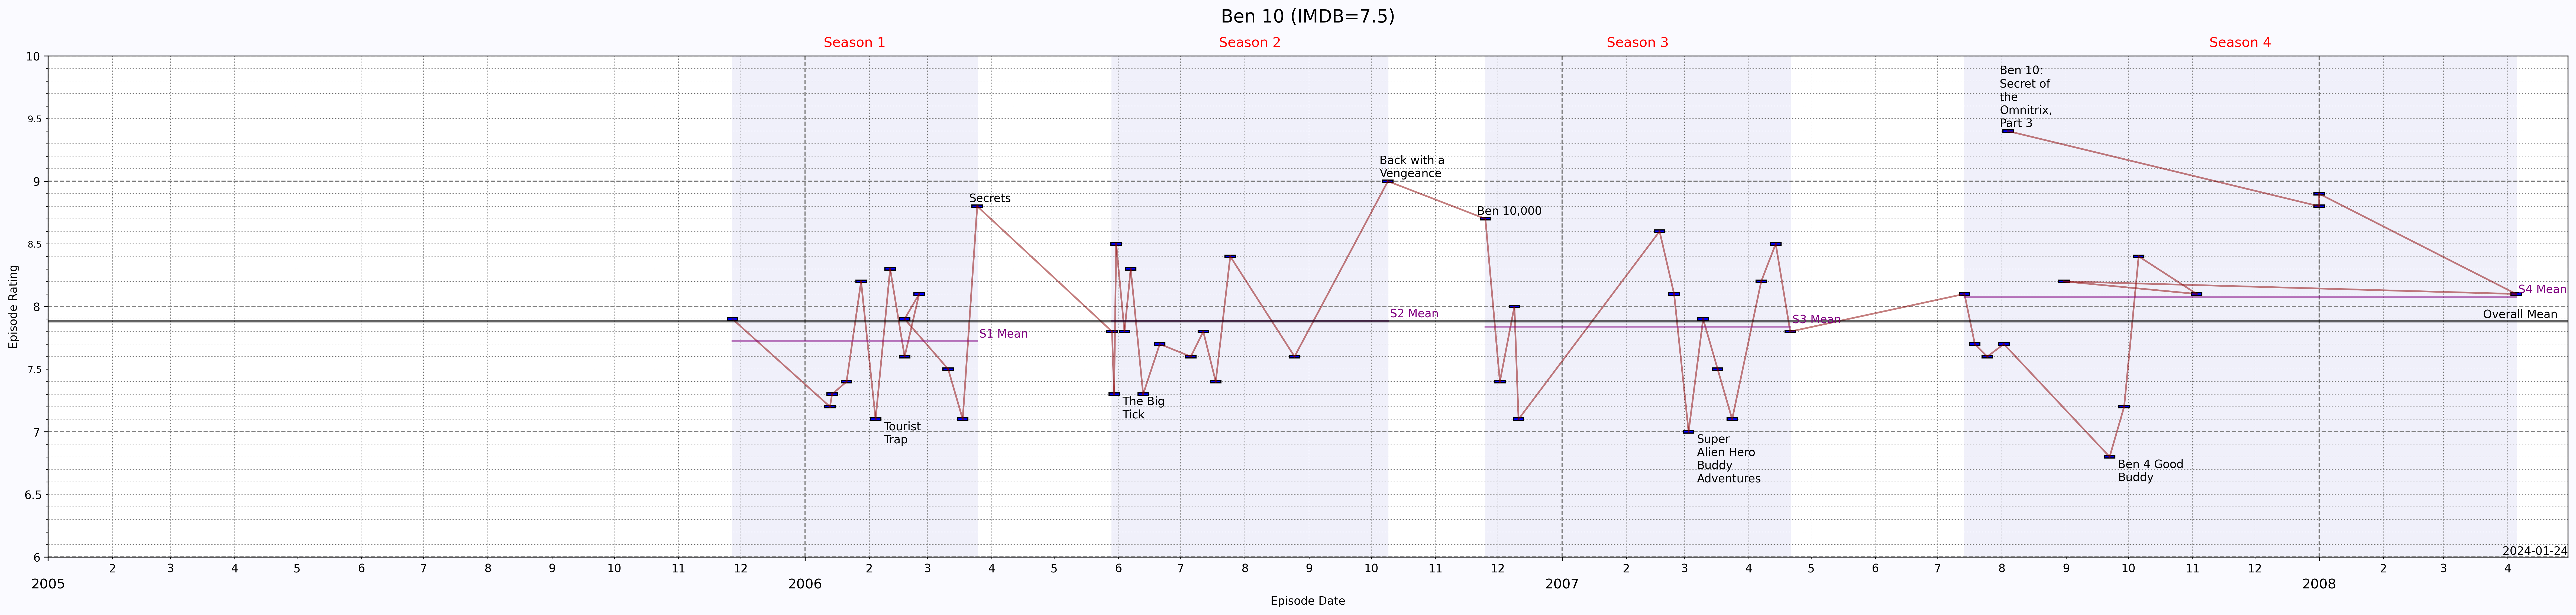

In [4]:
#Create a date based figure

# Create a figure and axis
fig, ax = plt.subplots(figsize=(40, 8),dpi=300)

# Define the width of each rectangle
rectangle_width = pd.to_timedelta(5,"d")
rectangle_height = 0.02


#Add Rectangles
addDataPoints(df,ax)

#Add plot line
addPlotLine(df,ax)
    
# Add season backgrounds
addseasonBackgrounds(df,ax)

# Add season means:
addSeasonMeans(df,ax)

# Add overall means:
addOverallMean(df,ax)

setAxes(ax)
setGrid(ax)

# Set Background color
fig.set_facecolor('#FAFAFF')

# Add todays date.
addDate(ax)

# Add Title
addTitle(plt,ax,df)

# Add min and max points
addMinandMaxData(ax,df,True)

# Show the plot
plt.show()